In [142]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore') 

11월 29일 실험 코드  
원본은 11_28  

1차 시도 : 이상치 제거 시 신뢰구간에 오실레이션 관측됨.   
이를 제거하기 위해 이상치 제거 코드에서 신뢰구간에 이동평균 도입  
1차 시도 결과 : (맘맘마 	2022-11-29 10:41:54	) 0.0015 감소, 결과와 별개로 안정성을 부여한다고 판단하여 이대로 진행하겠음.  

2차 시도 :  2차 이상치 제거 0.85 로 변경
2차 시도 결과 : (맘맘마 	2022-11-29 10:59:55		) 점수 증가.   

보충 : 이유는 모르겠지만 중간 확인을 위한 예측 코드를 바꾸는 것이 영향을 미치는 것 같아 _ 처리해서 변수명 분리함

3차 시도 : 2차 이상치 제거 0.75 로 변경
3차 시도 결과 : (b612 2022-11-29 11:04:20) 점수 증가.  2차 이상치 제거 기준은 0.8이 적정해 보임
   



In [143]:
def detect_anomalies_low(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted['yhat_upper'] = forecasted['yhat_upper'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted['yhat_lower'] = forecasted['yhat_lower'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    #forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1

    return forecasted

def detect_anomalies_up(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted['yhat_upper'] = forecasted['yhat_upper'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted['yhat_lower'] = forecasted['yhat_lower'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    #forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1


    return forecasted

def detect_anomalies_both(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted['yhat_upper'] = forecasted['yhat_upper'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted['yhat_lower'] = forecasted['yhat_lower'].rolling(window=3, closed = 'both', min_periods = 1).mean()
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1
    #forecasted['importance'] = 0
    #forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    #forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

    return forecasted
# 12월 3일 한번 바꿔봄 year_seasonaliity 없애고 chagne_point_range = 0,2,
# interval_width = 0.6

# 12월 3일 2차 수정

def fit_predict_model(dataframe, interval_width = 0.6, changepoint_range = 0.2):
    m = Prophet(interval_width = interval_width,
               changepoint_range = changepoint_range,
#                yearly_seasonality=2,
                seasonality_mode='multiplicative')
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

# gj_model = Prophet(
#     yearly_seasonality=2,
#                    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.6)


def get_view_result(df, target, forecast):
    viewd = df[['Date', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()
    
    after = forecast[['Date', target]]
    after = after.reset_index(drop=True)
    after = after.reset_index()
    
    print(target)
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.scatterplot(x='Date', y=target, data=viewd)
    sns.scatterplot(x='Date', y=target, data=after)
    plt.show()
    
def get_view(df, target):
    viewd = df[['Date', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()

    print(target)
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.scatterplot(x='Date', y=target, data=viewd)
    plt.show()
    
def get_view_anomal(df, target, anomal):
    viewd = df[['Date', target]]
    viewd = viewd.reset_index(drop=True)
    viewd = viewd.reset_index()

    print(target)
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.scatterplot(x='Date', y=target, data=viewd)
    plt.show()

In [144]:
import os 
os.chdir('C:\\Users\\pc\\Desktop\\UOS')

In [145]:
train_df = pd.read_csv('./train.csv')
train_df.head()

,일시,광진구,동대문구,성동구,중랑구
0,20180101,0.592,0.368,0.580,0.162
1,20180102,0.840,0.614,1.034,0.260
2,20180103,0.828,0.576,0.952,0.288
3,20180104,0.792,0.542,0.914,0.292
4,20180105,0.818,0.602,0.994,0.308


In [146]:
# train_df = train_df [365:]

In [147]:
train_df['Date'] = train_df['일시'].astype(str)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df.drop(['일시'], axis = 'columns')
train_df

,광진구,동대문구,성동구,중랑구,Date
0,0.592,0.368,0.580,0.162,2018-01-01
1,0.840,0.614,1.034,0.260,2018-01-02
2,0.828,0.576,0.952,0.288,2018-01-03
3,0.792,0.542,0.914,0.292,2018-01-04
4,0.818,0.602,0.994,0.308,2018-01-05
...,...,...,...,...,...
1456,3.830,3.416,2.908,2.350,2021-12-27
1457,4.510,3.890,3.714,2.700,2021-12-28
1458,4.490,3.524,3.660,2.524,2021-12-29
1459,4.444,3.574,3.530,2.506,2021-12-30


입력 데이터 생성

In [148]:
gj = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['광진구']
})
ddm = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['동대문구']
})
sd = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['성동구']
})
jr = pd.DataFrame({
    'ds' : train_df['Date'],
    'y' : train_df['중랑구']
})

## raw 데이터를 이용한 예측

In [149]:
gj_model = Prophet(
#     yearly_seasonality=2,
                   seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.6)
gj_model_1 = Prophet(
#     yearly_seasonality=2,
                   seasonality_mode='multiplicative', changepoint_range = 0.05,interval_width = 0.6)

# ddm_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.6)
# sd_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8, interval_width = 0.6)
# jr_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8, interval_width = 0.6)
# 모델 학습
gj_model.fit(gj)
gj_model_1.fit(gj)
# ddm_model.fit(ddm)
# sd_model.fit(sd)
# jr_model.fit(jr)

23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing
23:32:39 - cmdstanpy - INFO - Chain [1] start processing
23:32:39 - cmdstanpy - INFO - Chain [1] done processing


<!-- In-Sample Forecast -->

In [150]:
dates_ = pd.date_range('2019-1-1','2021-12-31')
last_1year_ = pd.DataFrame(dates_, columns = ['ds'])

In [151]:
gj_forecast_ = gj_model.predict(last_1year_)
gj_forecast_1 = gj_model_1.predict(last_1year_)
# ddm_forecast_ = ddm_model.predict(last_1year_)
# fd_orecast_ = sd_model.predict(last_1year_)
# jr_forecast_ = jr_model.predict(last_1year_)


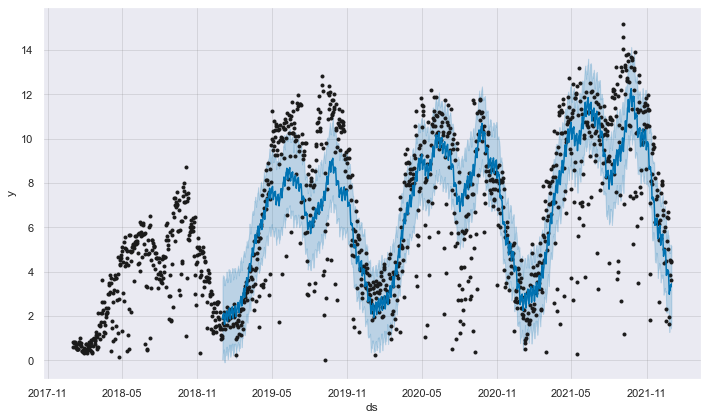

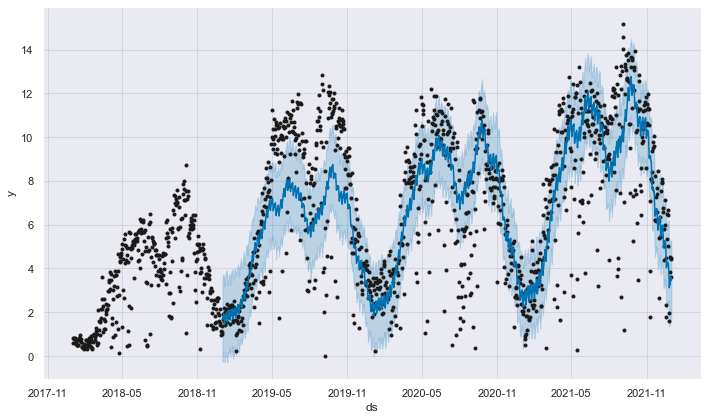

In [152]:
gj_model.plot(gj_forecast_)
gj_model_1.plot(gj_forecast_1)
# ddm_model.plot(ddm_forecast_)
# sd_model.plot(fd_orecast_)
# jr_model.plot(jr_forecast_)
pyplot.show()

## 아래 쪽 이상치 제거

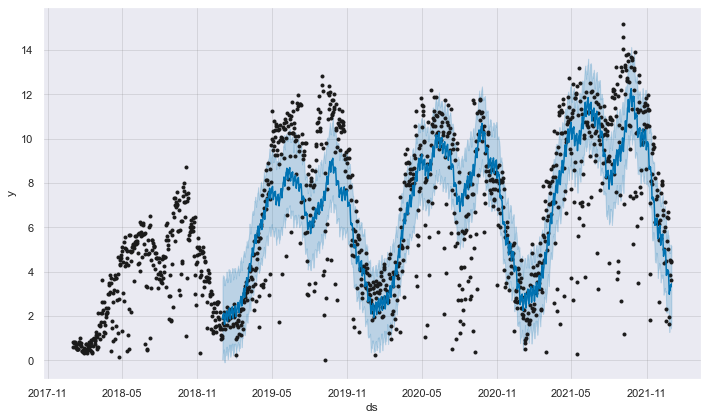

In [153]:
gj_model.plot(gj_forecast_)
pyplot.show()

In [154]:
# 첫번째는 0.7
# 두번재는 0.9

pred_gj = fit_predict_model(gj, interval_width = 0.7)
pred_gj = detect_anomalies_low(pred_gj)


pred_ddm = fit_predict_model(ddm, interval_width = 0.7)
pred_ddm = detect_anomalies_low(pred_ddm)

pred_sd = fit_predict_model(sd, interval_width = 0.7)
pred_sd = detect_anomalies_low(pred_sd)

pred_jr = fit_predict_model(jr, interval_width = 0.7)
pred_jr = detect_anomalies_low(pred_jr)

pred_gj.head()

23:32:54 - cmdstanpy - INFO - Chain [1] start processing
23:32:54 - cmdstanpy - INFO - Chain [1] done processing
23:32:55 - cmdstanpy - INFO - Chain [1] start processing
23:32:55 - cmdstanpy - INFO - Chain [1] done processing
23:32:56 - cmdstanpy - INFO - Chain [1] start processing
23:32:56 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly
0,2018-01-01,1.600287,0.542281,-1.428980,2.678551,0.592,0
1,2018-01-02,1.612814,0.551850,-1.430539,2.736503,0.840,0
2,2018-01-03,1.625342,0.612836,-1.447918,2.666267,0.828,0
3,2018-01-04,1.637869,0.610901,-1.481766,2.684628,0.792,0
4,2018-01-05,1.650396,0.653019,-1.492185,2.684475,0.818,0


In [155]:
gj_anomaly = pred_gj.anomaly == 1
ddm_anomaly = pred_ddm.anomaly == 1
sd_anomaly = pred_sd.anomaly == 1
jr_anomaly = pred_jr.anomaly == 1

print(sum(gj_anomaly), sum(ddm_anomaly), sum(sd_anomaly), sum(jr_anomaly))

171 172 170 158


In [156]:
pred_gj.iloc[gj_anomaly, 5] = np.nan
pred_ddm.iloc[ddm_anomaly, 5] = np.nan
pred_sd.iloc[sd_anomaly, 5] = np.nan
pred_jr.iloc[jr_anomaly, 5] = np.nan

# pred_gj.loc[:, 'fact'] = pred_gj.loc[:, 'fact'].interpolate()
# pred_ddm.loc[:, 'fact'] = pred_ddm.loc[:, 'fact'].interpolate()
# pred_sd.loc[:, 'fact'] = pred_sd.loc[:, 'fact'].interpolate()
# pred_jr.loc[:, 'fact'] = pred_jr.loc[:, 'fact'].interpolate()

In [157]:
dates = pd.date_range('2018-1-1','2021-12-31')
merge = pd.DataFrame({
    'Date' : dates,
    '광진구' : pred_gj.fact,
    '동대문구' : pred_ddm.fact,
    '성동구' : pred_sd.fact,
    '중랑구' : pred_jr.fact
})

광진구


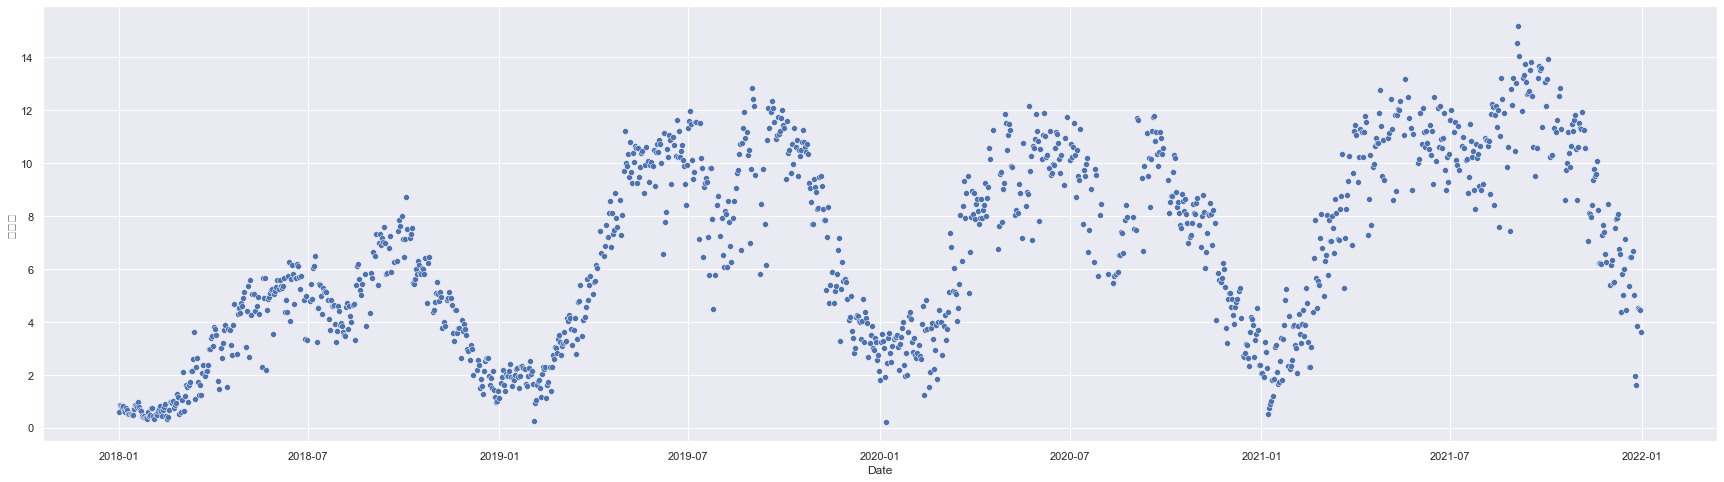

동대문구


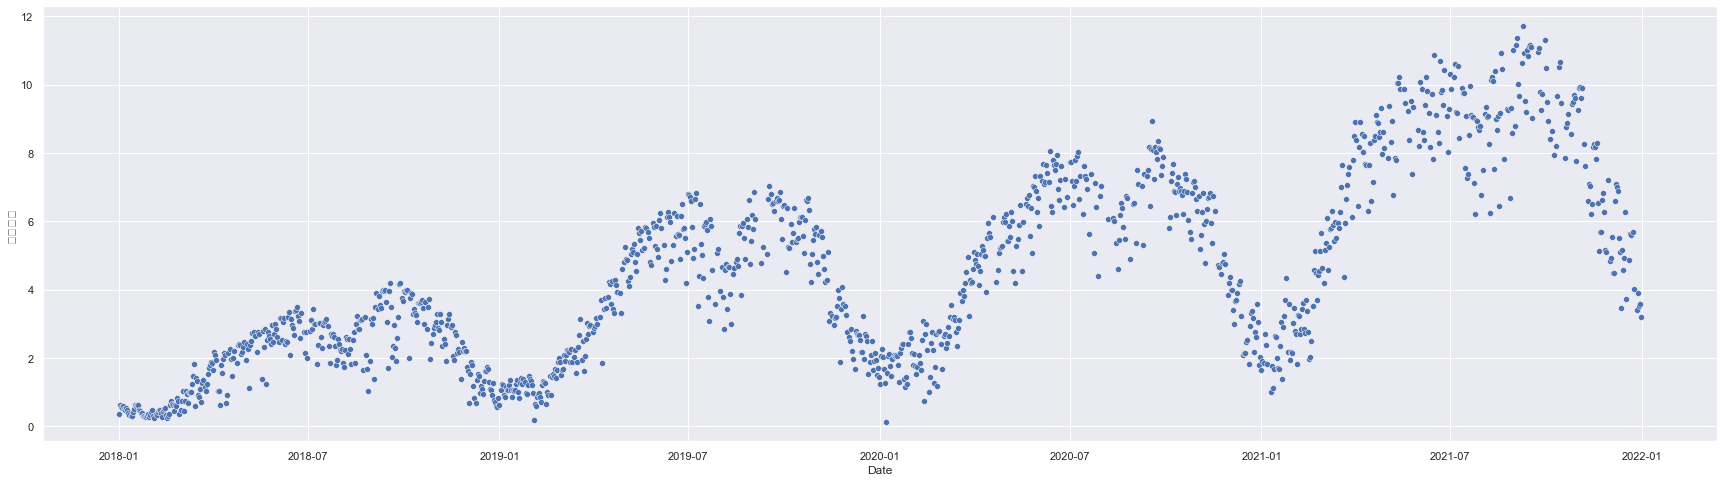

성동구


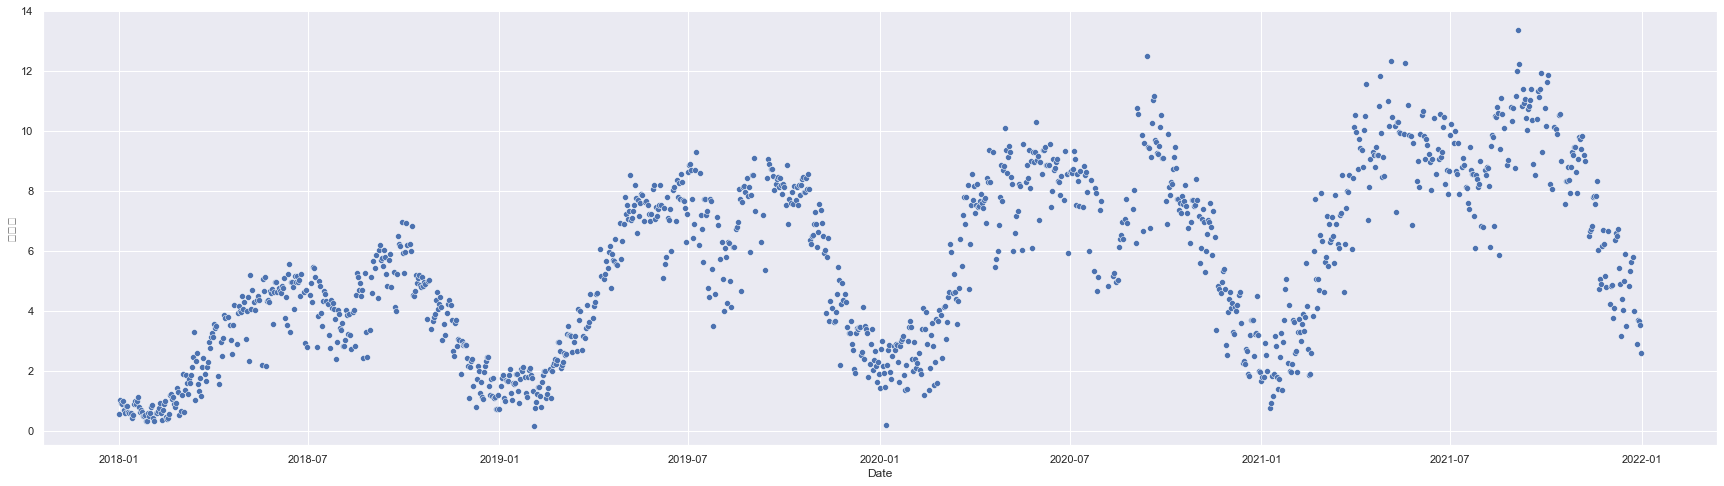

중랑구


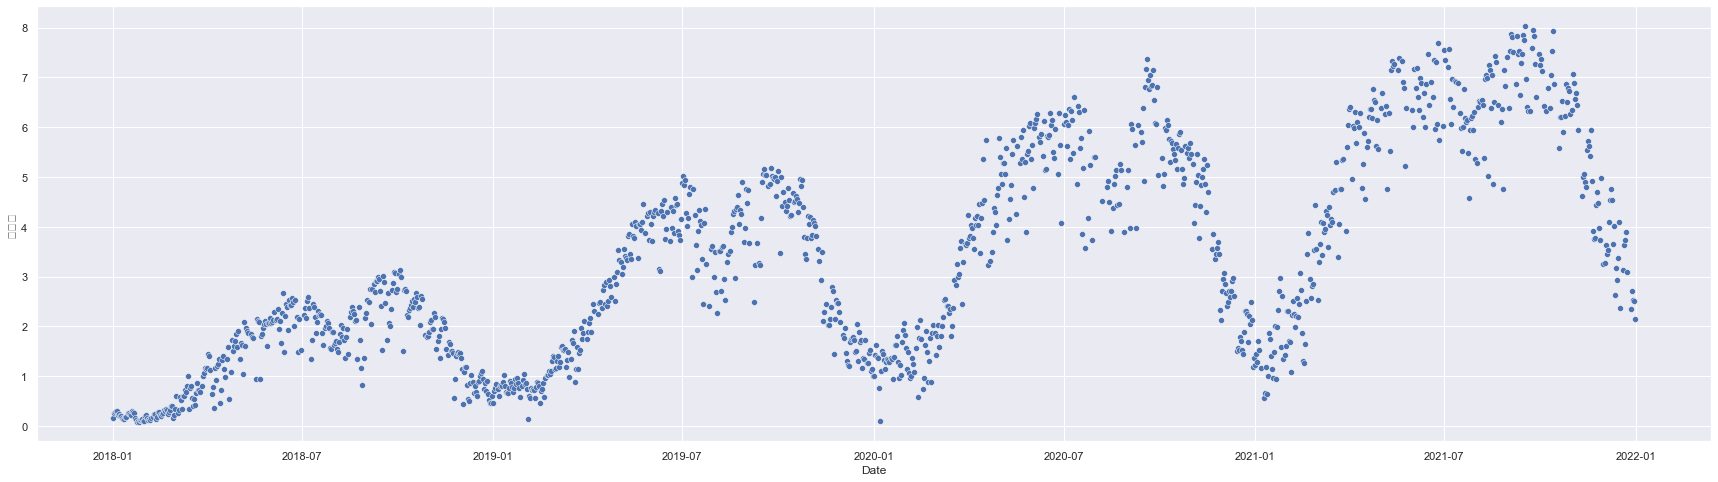

In [158]:
get_view(merge, '광진구')
get_view(merge, '동대문구')
get_view(merge, '성동구')
get_view(merge, '중랑구')

In [159]:
gj1 = pd.DataFrame({
    'ds' : pred_gj['ds'],
    'y' : pred_gj['fact']
})
ddm1 = pd.DataFrame({
    'ds' : pred_ddm['ds'],
    'y' : pred_ddm['fact']
})
sd1 = pd.DataFrame({
    'ds' : pred_sd['ds'],
    'y' : pred_sd['fact']
})
jr1 = pd.DataFrame({
    'ds' : pred_jr['ds'],
    'y' : pred_jr['fact']
})

예측 시도

In [161]:
# 예측 할대 year = 2
gj_model_ = Prophet(
    yearly_seasonality=2,
                    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)
ddm_model_ = Prophet(
    yearly_seasonality=2,
                     seasonality_mode='multiplicative', 
                     changepoint_range = 0.2, interval_width = 0.8)
sd_model_ = Prophet(
    yearly_seasonality=2,
    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)
jr_model_ = Prophet(
    yearly_seasonality=2,
    seasonality_mode='multiplicative', changepoint_range = 0.2, interval_width = 0.8)
# 모델 학습
gj_model_.fit(gj1)
ddm_model_.fit(ddm1)
sd_model_.fit(sd1)
jr_model_.fit(jr1)


23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:08 - cmdstanpy - INFO - Chain [1] done processing
23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:08 - cmdstanpy - INFO - Chain [1] done processing
23:34:08 - cmdstanpy - INFO - Chain [1] start processing
23:34:09 - cmdstanpy - INFO - Chain [1] done processing
23:34:09 - cmdstanpy - INFO - Chain [1] start processing
23:34:09 - cmdstanpy - INFO - Chain [1] done processing


In [162]:
dates_ = pd.date_range('2019-1-1','2021-12-31')
last_1year_ = pd.DataFrame(dates_, columns = ['ds'])

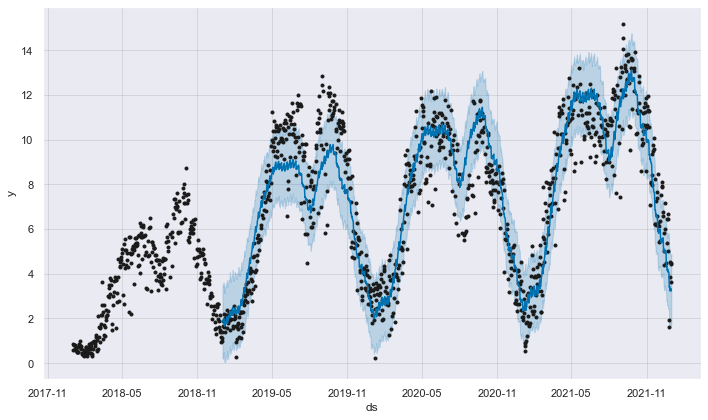

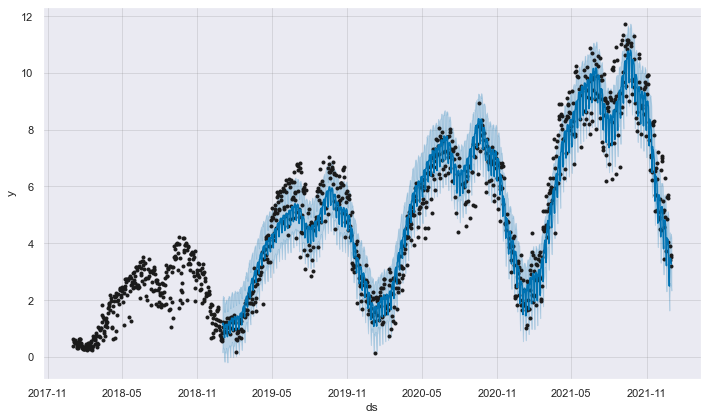

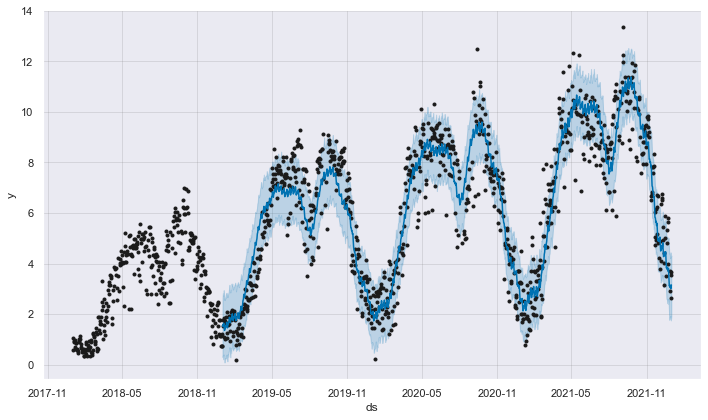

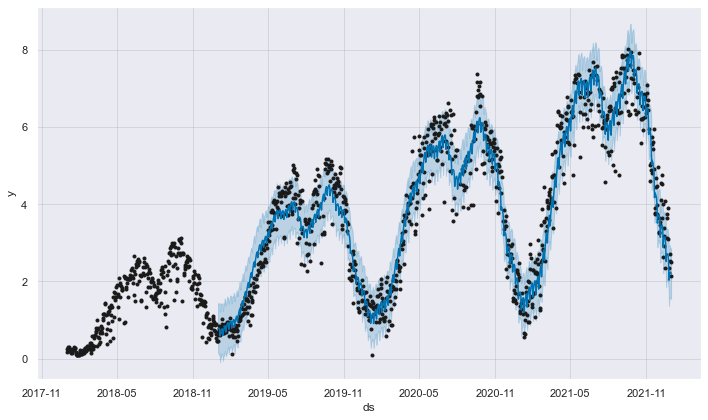

In [164]:
gj_forecast_ = gj_model_.predict(last_1year_)
ddm_forecast_ = ddm_model_.predict(last_1year_)
fd_orecast_ = sd_model_.predict(last_1year_)
jr_forecast_ = jr_model_.predict(last_1year_)

gj_model_.plot(gj_forecast_)
ddm_model_.plot(ddm_forecast_)
sd_model_.plot(fd_orecast_)
jr_model_.plot(jr_forecast_)
pyplot.show()

## 위쪽 이상치 제거

In [165]:
# 한번 만 함
pred_gj = fit_predict_model(gj1, interval_width = 0.7)
pred_gj = detect_anomalies_up(pred_gj)

pred_ddm = fit_predict_model(ddm1, interval_width = .7)
pred_ddm = detect_anomalies_up(pred_ddm)

pred_sd = fit_predict_model(sd1, interval_width = .7)
pred_sd = detect_anomalies_up(pred_sd)

pred_jr = fit_predict_model(jr1, interval_width = .7)
pred_jr = detect_anomalies_up(pred_jr)

pred_gj.head()

23:34:44 - cmdstanpy - INFO - Chain [1] start processing
23:34:45 - cmdstanpy - INFO - Chain [1] done processing
23:34:45 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:47 - cmdstanpy - INFO - Chain [1] done processing
23:34:47 - cmdstanpy - INFO - Chain [1] start processing
23:34:48 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly
0,2018-01-01,1.165992,0.367415,-1.249731,1.872821,0.592,0
1,2018-01-02,1.182160,0.353744,-1.193318,1.896317,0.840,0
2,2018-01-03,1.198328,0.378984,-1.225842,1.920199,0.828,0
3,2018-01-04,1.214496,0.377751,-1.250634,1.916368,0.792,0
4,2018-01-05,1.230665,0.401953,-1.184313,1.933809,0.818,0


In [166]:
gj_anomaly = pred_gj.anomaly == 1
ddm_anomaly = pred_ddm.anomaly == 1
sd_anomaly = pred_sd.anomaly == 1
jr_anomaly = pred_jr.anomaly == 1

print(sum(gj_anomaly), sum(ddm_anomaly), sum(sd_anomaly), sum(jr_anomaly))

140 143 118 122


In [167]:
pred_gj.iloc[gj_anomaly, 5] = np.nan
pred_ddm.iloc[ddm_anomaly, 5] = np.nan
pred_sd.iloc[sd_anomaly, 5] = np.nan
pred_jr.iloc[jr_anomaly, 5] = np.nan

# pred_gj.loc[:, 'fact'] = pred_gj.loc[:, 'fact'].interpolate()
# pred_ddm.loc[:, 'fact'] = pred_ddm.loc[:, 'fact'].interpolate()
# pred_sd.loc[:, 'fact'] = pred_sd.loc[:, 'fact'].interpolate()
# pred_jr.loc[:, 'fact'] = pred_jr.loc[:, 'fact'].interpolate()

In [168]:
dates = pd.date_range('2018-1-1','2021-12-31')
merge = pd.DataFrame({
    'Date' : dates,
    '광진구' : pred_gj.fact,
    '동대문구' : pred_ddm.fact,
    '성동구' : pred_sd.fact,
    '중랑구' : pred_jr.fact
})

광진구


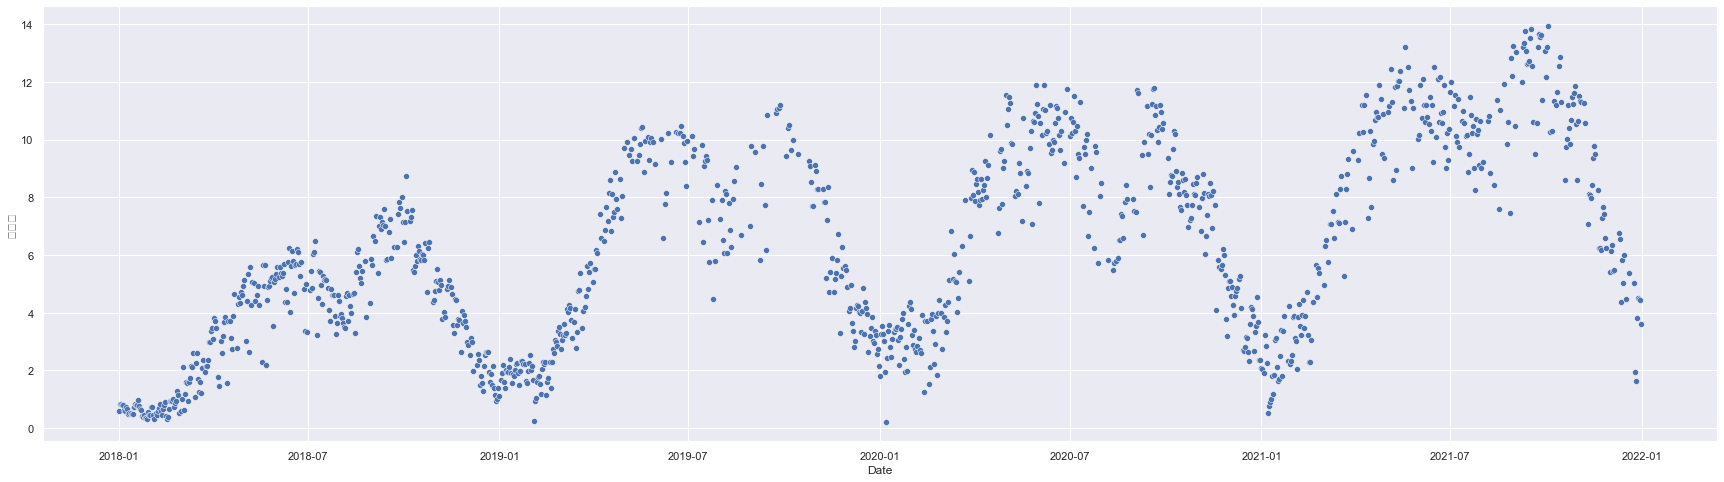

동대문구


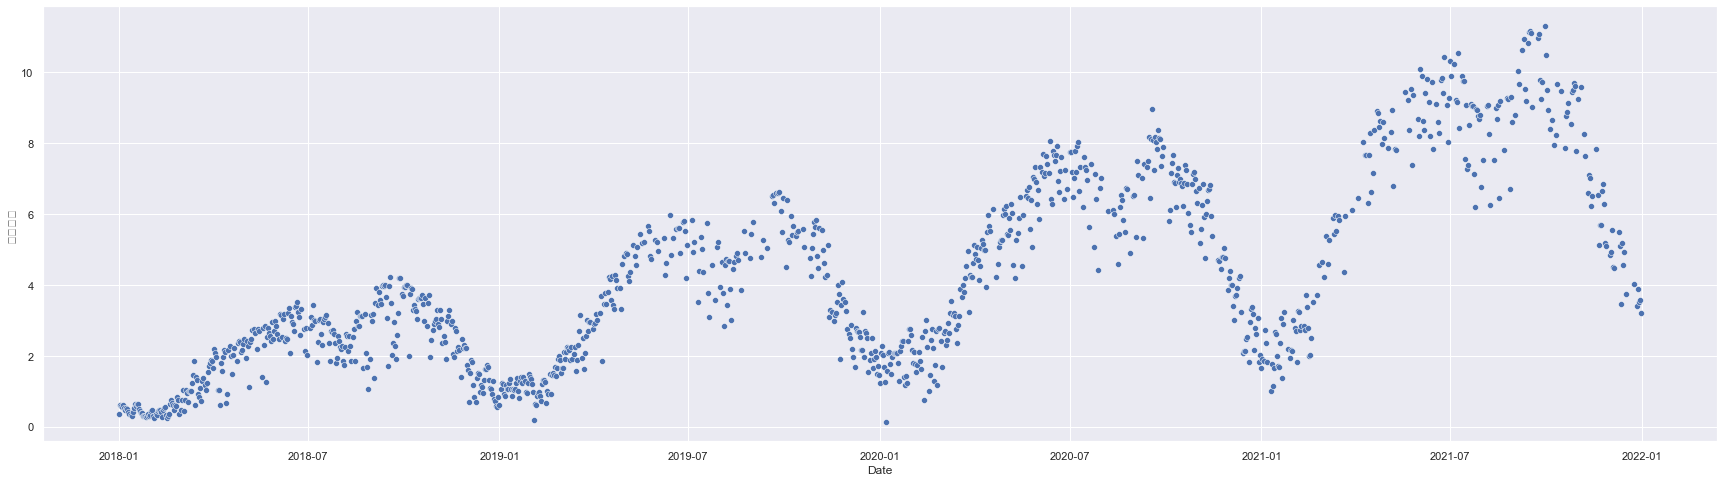

성동구


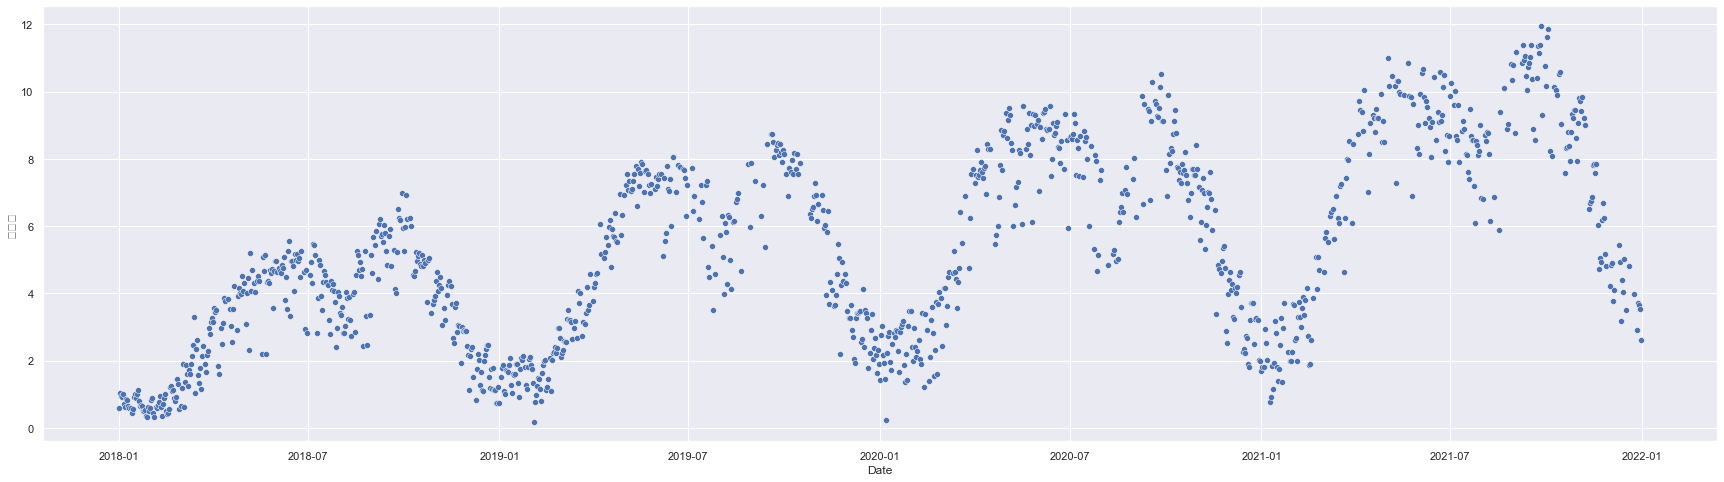

중랑구


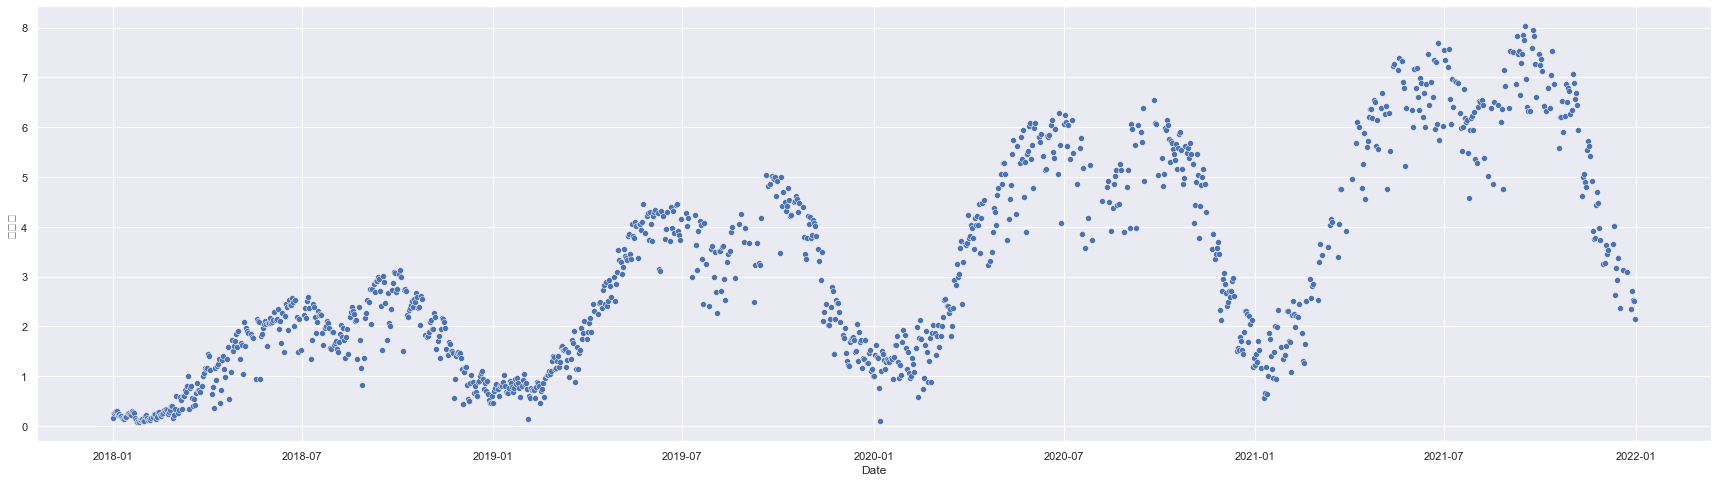

In [169]:
get_view(merge, '광진구')
get_view(merge, '동대문구')
get_view(merge, '성동구')
get_view(merge, '중랑구')

prophat을 이용한 예측

In [170]:
# mean으로 결측치 처리
gj1 = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['광진구'].rolling(window=3, closed = 'both', min_periods = 1).median()
})
ddm1 = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['동대문구'].rolling(window=3, closed = 'both', min_periods = 1).median()
})
sd1 = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['성동구'].rolling(window=3, closed = 'both', min_periods = 1).median()
})
jr1 = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['중랑구'].rolling(window=3, closed = 'both', min_periods = 1).median()
})

In [171]:
# max로 결측치 처리 # 이걸 채택
gj = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['광진구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
ddm = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['동대문구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
sd = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['성동구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})
jr = pd.DataFrame({
    'ds' : merge['Date'],
    'y' : merge['중랑구'].rolling(window=3, closed = 'both', min_periods = 1).max()
})

In [172]:
gj_model = Prophet(
#     yearly_seasonality=2,
    seasonality_mode='multiplicative', changepoint_range = 0.8)
ddm_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
sd_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
jr_model = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
# 모델 학습
gj_model.fit(gj)
ddm_model.fit(ddm)
sd_model.fit(sd)
jr_model.fit(jr)

23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:32 - cmdstanpy - INFO - Chain [1] done processing
23:36:32 - cmdstanpy - INFO - Chain [1] start processing
23:36:32 - cmdstanpy - INFO - Chain [1] done processing


In [173]:
gj_model_1 = Prophet(
#     yearly_seasonality=2,
                     seasonality_mode='multiplicative', changepoint_range = 0.8)
ddm_model_1 = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
sd_model_1 = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
jr_model_1 = Prophet(yearly_seasonality=2,seasonality_mode='multiplicative', changepoint_range = 0.8)
# 모델 학습
gj_model_1.fit(gj1)
ddm_model_1.fit(ddm1)
sd_model_1.fit(sd1)
jr_model_1.fit(jr1)

23:36:32 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing
23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing
23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing
23:36:33 - cmdstanpy - INFO - Chain [1] start processing
23:36:33 - cmdstanpy - INFO - Chain [1] done processing


In [174]:
dates = pd.date_range('2018-1-1','2022-11-30')
last_1year = pd.DataFrame(dates, columns = ['ds'])

In [175]:
gj_forecast = gj_model.predict(last_1year)
ddm_forecast = ddm_model.predict(last_1year)
fd_orecast = sd_model.predict(last_1year)
jr_forecast = jr_model.predict(last_1year)

In [176]:
gj_forecast_1 = gj_model.predict(last_1year)
ddm_forecast_1 = ddm_model.predict(last_1year)
fd_orecast_1 = sd_model.predict(last_1year)
jr_forecast_1 = jr_model.predict(last_1year)

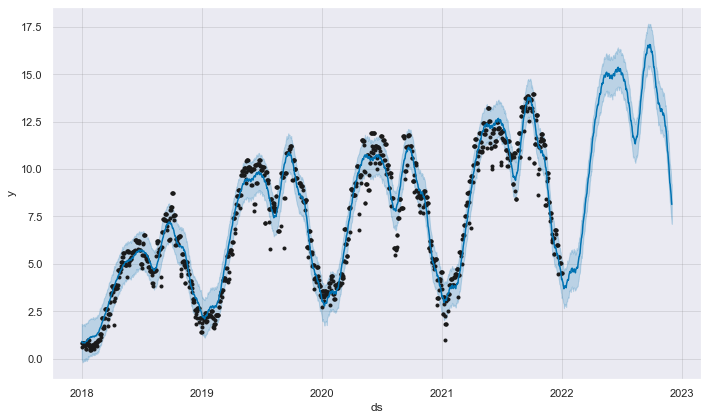

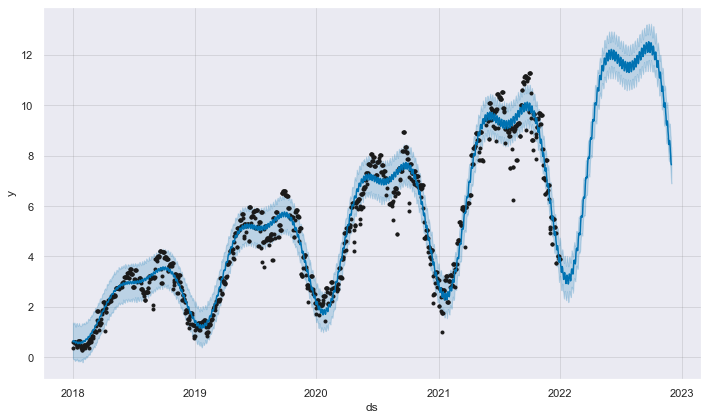

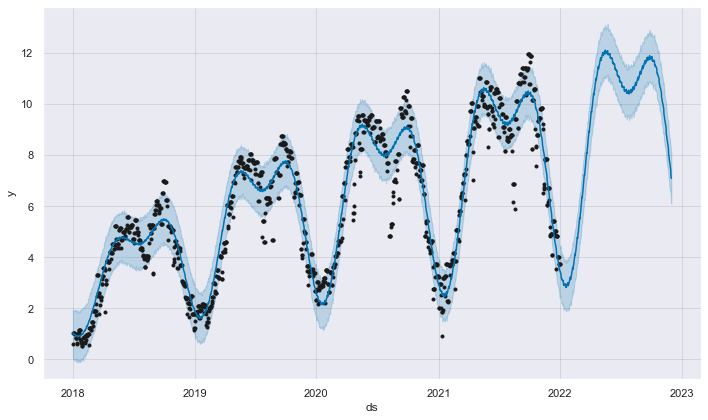

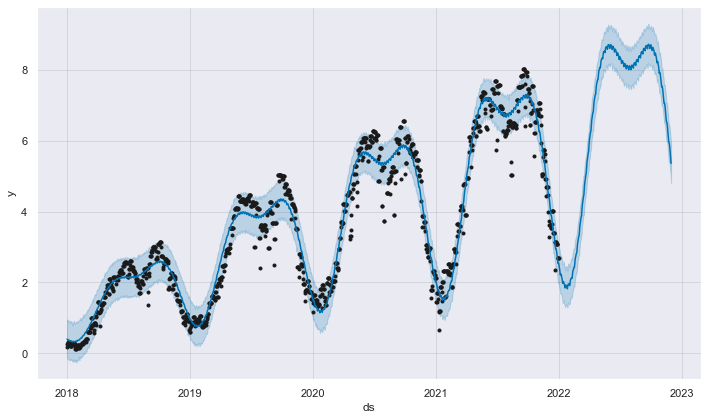

In [177]:
gj_model.plot(gj_forecast)
ddm_model.plot(ddm_forecast)
sd_model.plot(fd_orecast)
jr_model.plot(jr_forecast)
pyplot.show()

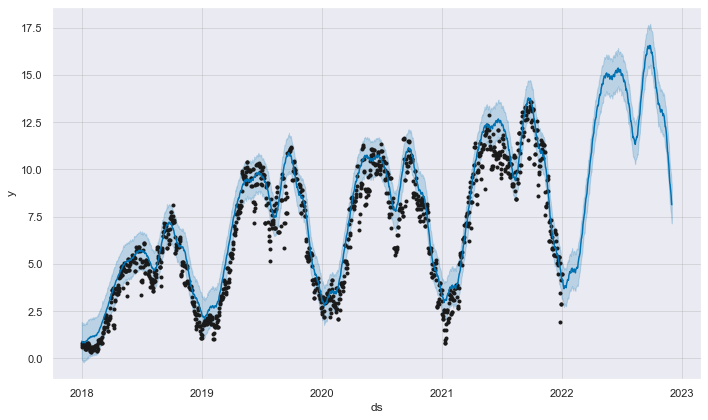

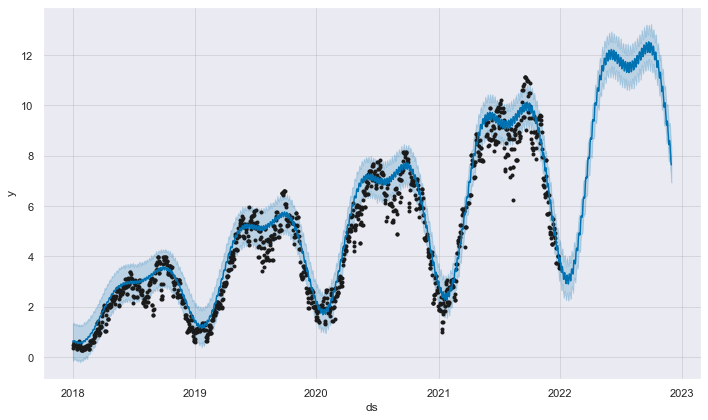

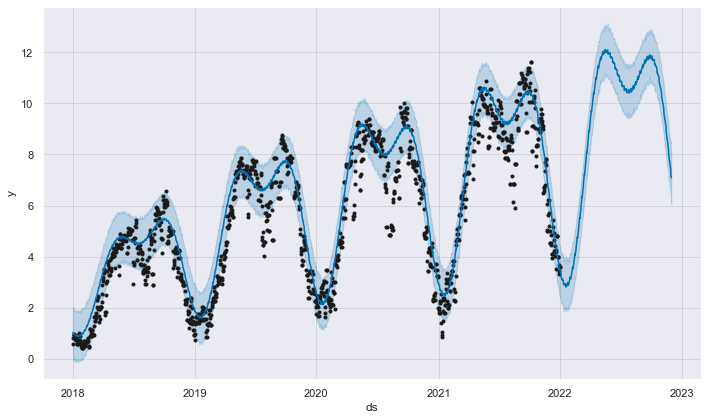

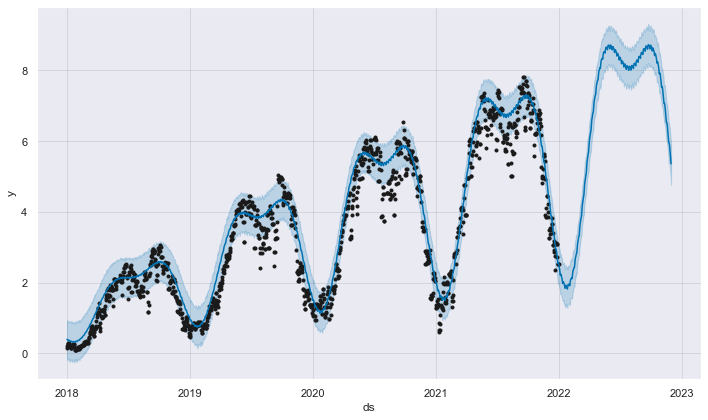

In [178]:
gj_model_1.plot(gj_forecast_1)
ddm_model_1.plot(ddm_forecast_1)
sd_model_1.plot(fd_orecast_1)
jr_model_1.plot(jr_forecast_1)
pyplot.show()

In [136]:
dates = pd.date_range('2022-1-1','2022-11-30')
after_1year = pd.DataFrame(dates, columns = ['ds'])

In [137]:
gj_forecast = gj_model.predict(after_1year)
ddm_forecast = ddm_model.predict(after_1year)
sd_forecast = sd_model.predict(after_1year)
jr_forecast = jr_model.predict(after_1year)

In [138]:
submit = pd.read_csv('./sample_submission.csv')
submit['광진구'] = gj_forecast['yhat'].round(3)
submit['동대문구'] = ddm_forecast['yhat'].round(3)
submit['성동구'] = sd_forecast['yhat'].round(3)
submit['중랑구'] = jr_forecast['yhat'].round(3)

In [139]:
submit.to_csv('./12_03_3.csv', index=False)

In [141]:
dates = pd.date_range('2022-1-1','2022-11-30')
after_1year = pd.DataFrame(dates, columns = ['ds'])
gj_forecast = gj_model_1.predict(after_1year)
ddm_forecast = ddm_model_1.predict(after_1year)
sd_forecast = sd_model_1.predict(after_1year)
jr_forecast = jr_model_1.predict(after_1year)
submit = pd.read_csv('./sample_submission.csv')
submit['광진구'] = gj_forecast['yhat'].round(3)
submit['동대문구'] = ddm_forecast['yhat'].round(3)
submit['성동구'] = sd_forecast['yhat'].round(3)
submit['중랑구'] = jr_forecast['yhat'].round(3)
submit.to_csv('./12_03_4.csv', index=False)